In [1]:
#setup
import pandas as pd
import numpy as np
from scipy import stats

load = pd.read_csv("../../data/train.csv")
ames = load.copy()
load.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [2]:
"""
Mike's Ames Housing Data Transformation block
Format:
# Variable: variable in ames df
# Problems: described issues (missingness, transformations, unbalanced categories)
# Solutions: transformations performed
my code
# (optional) Alternative: if the approach is low confidence, provide another strategy 
# (optional) alternative code
"""

### Variable: RoofStyle
# Problems: 6 categories, 4 of which were less than 1% of total counts
# Solution: Condense categories to most common (gable roof, 78%) and less common(Hip, Flat, etc...)
ames.RoofStyle = ['gable' if rs == 'Gable' else 'not_gable' for rs in ames.RoofStyle]
# gable is 'standard' construction type (vs hip)
# Alternative: evaluate as 'hip'; 2nd most common and a 'premium' roof style
#ames.RoofStyle = ['hip' if rs == 'Hip' else 'not_hip' for rs in ames.RoofStyle]

### Variable: RoofMatl
# Problems: 98% of roof materials are Composite Shingles
# Solution: drop, below our threshold of at least a 95%/5% class balance
ames.drop(columns = 'RoofMatl', inplace = True)

### NEW ### Variable: IsVinyl
# Problems: duplicate info between exterior1st, 2nd below
# Solution: Vinyl siding is a common, standard material for houses
vinylSd = pd.Series([1 if sdg == 'VinylSd' else 0 for sdg in ames.Exterior1st])
vinylSd2 = pd.Series([1 if sdg == 'VinylSd' else 0 for sdg in ames.Exterior2nd])
combVinyl = vinylSd + vinylSd2
isVinyl = ['yes' if val > 0 else 'no' for val in combVinyl]
ames['IsVinyl'] = isVinyl

### Variable: Exterior1st
# Problems: 
# Solution: combined above, drop the original column
ames.drop(columns = ['Exterior1st'], inplace = True)

### Variable: Exterior2nd
# Problems: 
# Solution: combined above, drop the original column
ames.drop(columns = ['Exterior2nd'], inplace = True)

### Variable: MasVnrType
# Problems: 8 missing values; 4 categories with 1 less than 1%
# Solution: Assume that it was skipped as type/area == 0; group into masvnr or no_masvnr
ames.MasVnrType.fillna('None', inplace = True)
ames.MasVnrType = ['no_masvnr' if mvt == 'None' else 'masvnr' for mvt in ames.MasVnrType]
# modify to divide into brick and stone and other
# Alternative: separate into brick/stone/none

### Variable: MasVnrArea
# Problems: 8 missing values; 59% zeros strongly skew linear model
# Solution: Assume that it was skipped as type/area == 0; MasVnrType may capture the variance
ames.drop(columns = ['MasVnrArea'], inplace = True)
# Alternative: per ecology models, map for binary (as above for type) and then take log value of the number if > 0 

### Variable: ExterQual
# Problems: 3 categories (Excellent/Fair/Poor) < 5%; note that poor is not in training set
# Solution: Combine on a 'quality' split (Excellent/Good) and (Average/Fair/Poor) [37/63% split, respectively]
ames.ExterQual = ['high' if eq in ['Ex', 'Gd'] else 'low' for eq in ames.ExterQual]

### Variable: ExterCond
# Problems: as above, unbalanced classes with 3 categories < 5%
# Solution: Combine on same 'quality' split as above. Note Average is 88%, Good is 10%.
ames.ExterCond = ['high' if ec in ['Ex', 'Gd'] else 'low' for ec in ames.ExterCond]
### Alternative: pvalue=0.0488; given 80 repeated tests this is likely a FP 
# ames.drop(columns = ['ExterCond'])

### Variable: Foundation
# Problems: unbalanced classes with 3 categories < 5%
# Solution: Given adhoc knowledge (https://goo.gl/gDjDyc), Pconc is preferred foundation so group by pconc vs other
ames.Foundation = ['pconc' if fou == 'PConc' else 'other' for fou in ames.Foundation]

### Variable: BsmtQual ## NB ## 'quality' refers to the *height* of the basement. 
# Problems: NaN is defined as 'no basement'; 2 categories < 5%
# Solution: As above, collapse Ex/Gd as 'high'. Note, not having a basement (NB) is grouped with Average(TA)/Fa/Po
ames.BsmtQual = ['high' if bq in ['Ex', 'Gd'] else 'low' for bq in ames.BsmtQual]

### Variable: BsmtCond
# Problems: NaN is defined as 'no basement'; 4 categories below
# Solution: replace NaN with 'NB'; collapse categories as above
ames.BsmtCond = ['high' if bcond in ['Ex', 'Gd'] else 'low' for bcond in ames.BsmtCond]

### Variable: BsmtExposure
# Problems: 38 missing values; opportunity to condense into binary (decent basement exposure vs poor/no exposure)
# Solution: 37/38 values had TotalBsmtSF == 0 so set to no basement; collapsed categories
ames.BsmtExposure = ['exposure' if bex in ['Av', 'Gd', 'Mn'] else 'no_exposure' for bex in ames.BsmtExposure]

### Variable: BsmtFinType1
# Problems: diverse categories; opportunity to condense into developed or undeveloped(no basement, low quality, unfinished)
# Solution: condense into developed or undeveloped basement type
ames.BsmtFinType1 = ['undeveloped' if bt in ['Unf', 'LwQ', 'NB'] else 'developed' for bt in ames.BsmtFinType1]

### Variable: BsmtFinSF1
# Problems: BsmtFinSF1 + BsmtFinSF2 + BsmtUnf = TotalBsmtSF
# Solution: drop
ames.drop(columns = ['BsmtFinSF1'], inplace = True)

### double check that BsmtFinSF1 is largest component 

### Variable: BsmtFinType2
# Problems: pvalue=0.073; not statistically significant between developed or undeveloped on SalePrice
# Solution: drop
ames.drop(columns = ['BsmtFinType2'], inplace = True)

### Variable: BsmtFinSF2
# Problems: 59% zeroes. BsmtFinSF1 + BsmtFinSF2 + BsmtUnf = TotalBsmtSF
# Solution: drop
ames.drop(columns = ['BsmtFinSF2'], inplace = True)

### Variable: BsmtUnfSF
# Problems: BsmtFinSF1 + BsmtFinSF2 + BsmtUnf = TotalBsmtSF
# Solution: drop
ames.drop(columns = ['BsmtUnfSF'], inplace = True)

### Variable: TotalBsmtSF
# Problems: small bimodal hump from zero basements, ought to be corrected
# Solution: define bsmt sizes in quartiles, using quartile splits from training set
ames.TotalBsmtSF = ['small' if sf < 795.75 else 'mlow' if sf < 991.50 else 'mhigh' if sf < 1298.25 else 'large' for sf in ames.TotalBsmtSF]
# Alternative: scale using Robust Scaler?

### Variable: Heating
# Problems: Almost 98% of categories are 'GasA' so highly unequal classes
# Solution: drop
ames.drop(columns = ['Heating'], inplace = True)

### Variable: HeatingQC
# Problems: 2 categories < %5, opportunity to condense Ex/Gd as before
# Solution: Combine on a 'quality' split (Excellent/Good) and (Average/Fair/Poor) [67/33% split, respectively]
ames.HeatingQC = ['high' if hqc in ['Ex', 'Gd'] else 'low' for hqc in ames.HeatingQC]

In [3]:
print(ames.shape)
ames.iloc[:, 21:32].head(5)

(1460, 73)


,RoofStyle,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,TotalBsmtSF,HeatingQC
0,gable,masvnr,high,low,pconc,high,low,no_exposure,developed,mlow,high
1,gable,no_masvnr,low,low,other,high,low,exposure,developed,mhigh,high
2,gable,masvnr,high,low,pconc,high,low,exposure,developed,mlow,high
3,gable,no_masvnr,low,low,other,low,high,no_exposure,developed,small,high
4,gable,masvnr,high,low,pconc,high,low,exposure,developed,mhigh,high


In [4]:
my_ames = ames.iloc[:, 21:32]

In [5]:
print(pd.get_dummies(my_ames, drop_first = True).shape)
pd.get_dummies(my_ames, drop_first = True).head(5)

(1460, 13)


,RoofStyle_not_gable,MasVnrType_no_masvnr,ExterQual_low,ExterCond_low,Foundation_pconc,BsmtQual_low,BsmtCond_low,BsmtExposure_no_exposure,BsmtFinType1_undeveloped,TotalBsmtSF_mhigh,TotalBsmtSF_mlow,TotalBsmtSF_small,HeatingQC_low
0,0,0,0,1,1,0,1,1,0,0,1,0,0
1,0,1,1,1,0,0,1,0,0,1,0,0,0
2,0,0,0,1,1,0,1,0,0,0,1,0,0
3,0,1,1,1,0,1,0,1,0,0,0,1,0
4,0,0,0,1,1,0,1,0,0,1,0,0,0


<Figure size 936x936 with 0 Axes>

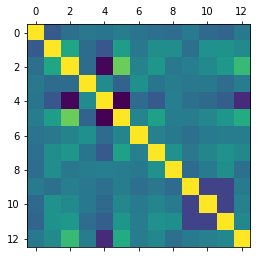

In [17]:
binary_my_ames = pd.get_dummies(my_ames, drop_first = True)
import matplotlib.pyplot as plt
plt.matshow(binary_my_ames.corr())